<a href="https://colab.research.google.com/github/AUT-Student/NN-HW3/blob/main/NN_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from copy import deepcopy

# Dataset

In [2]:
!gdown https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip -O "/content/Dataset.zip"

Downloading...
From: https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
To: /content/Dataset.zip
100% 61.0M/61.0M [00:03<00:00, 16.6MB/s]


In [3]:
!unzip /content/Dataset.zip

Archive:  /content/Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HA

In [4]:
!gdown https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names -O "/content/Dataset.names"

Downloading...
From: https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names
To: /content/Dataset.names
100% 6.30k/6.30k [00:00<00:00, 8.60MB/s]


In [5]:
!cat "/content/Dataset.names"

Human Activity Recognition Using Smartphones Dataset
Version 1.0
Jorge L. Reyes-Ortiz(1,2), Davide Anguita(1), Alessandro Ghio(1), Luca Oneto(1) and Xavier Parra(2)
1 - Smartlab - Non-Linear Complex Systems Laboratory
DITEN - Universit�  degli Studi di Genova, Genoa (I-16145), Italy. 
2 - CETpD - Technical Research Centre for Dependency Care and Autonomous Living
Universitat Polit�cnica de Catalunya (BarcelonaTech). Vilanova i la Geltr� (08800), Spain
activityrecognition '@' smartlab.ws 

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained data

In [6]:
!cat "/content/UCI HAR Dataset/activity_labels.txt"

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING


In [7]:
X_train = pd.read_csv("/content/UCI HAR Dataset/train/X_train.txt", delimiter=r"\s+", header=None)
X_test = pd.read_csv("/content/UCI HAR Dataset/test/X_test.txt", delimiter=r"\s+", header=None)
y_train = pd.read_csv("/content/UCI HAR Dataset/train/y_train.txt", delimiter=r"\s+", header=None)
y_test = pd.read_csv("/content/UCI HAR Dataset/test/y_test.txt", delimiter=r"\s+", header=None)

In [8]:
X_train["Class"] = y_train
X_test["Class"] = y_test

In [9]:
X_valid, X_train = np.split(X_train.sample(frac=1, random_state=0), [int(.125*len(X_train))])

In [10]:
y_train = X_train["Class"]
X_train = X_train.drop(columns=["Class"])

y_valid = X_valid["Class"]
X_valid = X_valid.drop(columns=["Class"])

In [11]:
y_train = y_train.apply(lambda x:x-1)
y_test = y_test.apply(lambda x:x-1)
y_valid = y_valid.apply(lambda x:x-1)

# MLP Classifer

## Model

In [ ]:
class MLPModel(keras.Model):
  def __init__(self, number_hidden_layers, number_hidden_units):
    super().__init__()

    if number_hidden_layers<0:
      raise Exception("The number of hidden layers must be a non-negetive number")

    if number_hidden_layers != len(number_hidden_units):
      raise Exception("The number of hidden layers must equal to the length of the number of hidden units list")

    self.model = keras.models.Sequential()

    for i in range(number_hidden_layers):
      self.model.add(keras.layers.Dense(units=number_hidden_units[i], activation="relu", name=f"Dense_Layer_{i+1}"))

    self.model.add(keras.layers.Dense(6, activation="softmax", name="Output_Layer"))

  def call(self, inputs):
    return self.model(inputs)

In [ ]:
def train_and_evaluate(number_hidden_layers, number_hidden_units, learning_rate):
  es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5)

  model = MLPModel(number_hidden_layers=number_hidden_layers, number_hidden_units=number_hidden_units)

  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  model.fit(x=X_train, y=y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=0, callbacks=[es_callback])

  train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
  validation_accuracy = model.evaluate(X_valid, y_valid, verbose=0)[1]

  print(f"Train = {round(train_accuracy*100, 2)}, Validation = {round(validation_accuracy*100, 2)}")

## Learning Rate Fine-tuning

In [ ]:
for learning_rate in [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.1]:
  print(f"Learning Rate = {learning_rate}")
  train_and_evaluate(number_hidden_layers=3, number_hidden_units=[128, 64, 32], learning_rate=0.001)
  print("")

Learning Rate = 0.0001
Train = 98.83, Validation = 97.71

Learning Rate = 0.0005
Train = 98.85, Validation = 97.82

Learning Rate = 0.001
Train = 97.95, Validation = 96.52

Learning Rate = 0.003
Train = 98.8, Validation = 98.04

Learning Rate = 0.005
Train = 98.4, Validation = 97.17

Learning Rate = 0.01
Train = 98.77, Validation = 97.93

Learning Rate = 0.1
Train = 98.57, Validation = 97.93



## Number Layer and Number Neuron Fine-tuning

In [ ]:
train_and_evaluate(number_hidden_layers=0, number_hidden_units=[], learning_rate=0.003)
print("")

Train = 98.82, Validation = 97.93



In [ ]:
for number_hidden_units in [[32], [64], [128]]:
  print(f"number_hidden_units = {number_hidden_units}")
  train_and_evaluate(number_hidden_layers=1, number_hidden_units=number_hidden_units, learning_rate=0.003)
  print("")

number_hidden_units = [32]
Train = 98.96, Validation = 97.93

number_hidden_units = [64]
Train = 98.87, Validation = 97.82

number_hidden_units = [128]
Train = 98.87, Validation = 98.04



In [ ]:
for number_hidden_units in [
                            [32, 32], [64, 32], [128, 128]
                            ]:
  print(f"number_hidden_units = {number_hidden_units}")
  train_and_evaluate(number_hidden_layers=2, number_hidden_units=number_hidden_units, learning_rate=0.003)
  print("")

number_hidden_units = [32, 32]
Train = 98.87, Validation = 98.26

number_hidden_units = [64, 32]
Train = 98.4, Validation = 97.06

number_hidden_units = [128, 128]
Train = 97.28, Validation = 96.63



In [ ]:
for number_hidden_units in [
                            [64, 32, 32], [64, 64, 64], [128, 64, 32]
                            ]:
  print(f"number_hidden_units = {number_hidden_units}")
  train_and_evaluate(number_hidden_layers=3, number_hidden_units=number_hidden_units, learning_rate=0.003)
  print("")

number_hidden_units = [64, 32, 32]
Train = 98.49, Validation = 97.71

number_hidden_units = [64, 64, 64]
Train = 98.15, Validation = 97.39

number_hidden_units = [128, 64, 32]
Train = 98.26, Validation = 97.28



In [ ]:
for number_hidden_units in [
                            [128, 128, 64, 64], [128, 64, 32, 16], [128, 64, 32, 64]
                            ]:
  print(f"number_hidden_units = {number_hidden_units}")
  train_and_evaluate(number_hidden_layers=4, number_hidden_units=number_hidden_units, learning_rate=0.05)
  print("")

number_hidden_units = [128, 128, 64, 64]
Train = 18.76, Validation = 18.17

number_hidden_units = [128, 64, 32, 16]
Train = 52.45, Validation = 50.82

number_hidden_units = [128, 64, 32, 64]
Train = 18.76, Validation = 18.17



# SOM

In [58]:
import colorsys

class SOM():
  def __init__(self, number_epochs, map_size, number_features,
               initial_learning_rate, initial_radius, radius_decay, X_train):
    
    self.number_epochs = number_epochs
    self.map_size = map_size
    self.number_features = number_features
    self.learning_rate = initial_learning_rate
    self.radius_decay = radius_decay
    self.radius = initial_radius
    self.initial_learning_rate = initial_learning_rate
    self._initiate_weight(X_train)

  def _initiate_weight(self, X_train):

    self.weight = []
    for i in range(self.map_size[0]):
      row_list = []
      for j in range(self.map_size[1]):
        row_list.append(X_train[np.random.choice(X_train.shape[0])])
      self.weight.append(row_list)
    self.weight = np.array(self.weight)

  def train(self, X_train):
    self.weight_changes_list = []
    self.dead_neurons_number_list = []
    self.mean_winner_distance_list = []

    for epoch in range(self.number_epochs):
      print(f"epoch = {epoch}")

      winner_set = set()
      mean_winner_distance = 0
      prev_weight = deepcopy(self.weight)

      for i, row in enumerate(X_train):
        winner = self.find_winner(row)

        winner_set.add(winner)
        mean_winner_distance += self.distance(self.weight[winner[0]][winner[1]], row)

        NS = self.calculate_NS(row, winner)
        self.update_weights(NS, row)

      self.weight_changes_list.append(np.linalg.norm(prev_weight - self.weight))
      self.dead_neurons_number_list.append(self.map_size[0]*self.map_size[1]-len(winner_set))
      self.mean_winner_distance_list.append(mean_winner_distance / len(X_train))

      self.learning_rate -= (self.initial_learning_rate/self.number_epochs)
      self.radius *= self.radius_decay

  def find_winner(self, row):
    winner = np.argmin(np.sum((np.tile(row, (self.map_size[0], self.map_size[1], 1)) - self.weight)**2, axis=2))
    winner = (winner//self.map_size[1], winner%self.map_size[1])
    return winner

  def calculate_NS(self, row, winner):
    NS = np.zeros(self.map_size)

    for i in range( max(winner[0]-int(self.radius), 0), min(winner[0]+int(self.radius)+1, self.map_size[0])):
      for j in range( max(winner[1]-int(self.radius), 0), min(winner[1]+int(self.radius)+1, self.map_size[1])):
          neuron_distance = self.distance(np.array((i, j)), np.array(winner))

          if neuron_distance <= self.radius:
            NS[i][j] = 1 - neuron_distance / self.radius
    
    return NS

  def update_weights(self, NS, row):
    Delta = np.tile(row , (self.map_size[0], self.map_size[1], 1)) - self.weight
    self.weight += self.learning_rate * np.multiply(np.tile(NS.T, (self.number_features, 1, 1)).T, Delta)

  def plot_map(self, X_train, y_train):
    number_labels = len(set(y_train))
    scores = np.zeros((self.map_size[0], self.map_size[1], number_labels))

    for i in range(len(X_train)):
      row = X_train[i]
      label = y_train[i]
      winner = self.find_winner(row)
      scores[winner[0]][winner[1]][label] += 1

    self._plot_clusters(number_labels, scores)
    self._plot_U_matrix(scores)

  def plot_train_state(self):
    self._plot_weight_changes()
    self._plot_dead_neurons_number()
    self._plot_mean_winner_distance()

  def _plot_clusters(self, number_labels, scores):
    label_colors = self._get_colors(number_labels)

    map_color = np.zeros((self.map_size[0], self.map_size[1], 3))

    for i in range(self.map_size[0]):
      for j in range(self.map_size[1]):
        if np.all(scores[i][j] == 0):
          map_color[i][j] = (0, 0, 0)
        else:
          map_color[i][j] = label_colors[np.argmax(scores[i][j])]
    
    plt.title("Clusters (Top Class)")
    plt.imshow(map_color)
    plt.show()


    map_color = np.zeros((self.map_size[0], self.map_size[1], 3))
    
    for i in range(self.map_size[0]):
      for j in range(self.map_size[1]):
        if np.all(scores[i][j] == 0):
          map_color[i][j] = (0, 0, 0)
        else:
          for k in range(number_labels):
            a = scores[i][j][k] / np.sum(scores[i][j])
            map_color[i][j] += np.array(list(map( lambda x:a*x, label_colors[k])))

    plt.title("Clusters (All Classes)")
    plt.imshow(map_color)
    plt.show()


  def _plot_U_matrix(self, scores):
    map_color = np.zeros((self.map_size[0], self.map_size[1]))
    
    for i in range(self.map_size[0]):
      for j in range(self.map_size[1]):
        map_color[i][j] = np.sum(scores[i][j])

    plt.title("U-Matrix")
    plt.imshow(map_color, cmap="hot")
    plt.show()

  def _plot_weight_changes(self):
    plt.xlabel("Epoch")
    plt.ylabel("Weight Change")
    plt.title("Weight Changing Over Epochs")
    plt.plot(self.weight_changes_list, color="purple")
    plt.show()

  def _plot_dead_neurons_number(self):
    plt.xlabel("Epoch")
    plt.ylabel("Dead Neurons")
    plt.title("Dead Neuron Number Over Epochs")
    plt.plot(self.dead_neurons_number_list, color="purple")
    plt.show()

  def _plot_mean_winner_distance(self):
    plt.xlabel("Epoch")
    plt.ylabel("Mean Winner Distance")
    plt.title("Mean Winner Distance Over Epochs")
    plt.plot(self.mean_winner_distance_list, color="purple")
    plt.show()

  def transform_row(self, row):
    distance_row = np.sum((np.tile(row, (self.map_size[0], self.map_size[1], 1)) - self.weight)**2, axis=2).flatten()
    transformed_row = np.array(list(map(lambda x:1/(x+1), distance_row)))
    return transformed_row

  def transform(self, X):
    return np.array([self.transform_row(x) for x in X])

  @staticmethod
  def distance(array1, array2):
    return np.linalg.norm(array1 - array2)

  @staticmethod
  def _get_colors(num_colors):
      colors=[]
      for i in np.arange(0., 360., 360. / num_colors):
          hue = i/360.
          lightness = (50 + np.random.rand() * 10)/100.
          saturation = (90 + np.random.rand() * 10)/100.
          colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
      return colors

In [59]:
som = SOM(number_epochs=20, map_size=(10,10), number_features=len(X_train.columns),
               initial_learning_rate=0.001, initial_radius=5,
               radius_decay=0.95, X_train=X_train.to_numpy())

In [62]:
som.train(X_train.to_numpy())

epoch = 0
epoch = 1
epoch = 2
epoch = 3
epoch = 4
epoch = 5
epoch = 6
epoch = 7
epoch = 8
epoch = 9
epoch = 10
epoch = 11
epoch = 12
epoch = 13
epoch = 14
epoch = 15
epoch = 16
epoch = 17
epoch = 18
epoch = 19


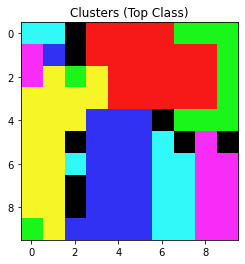

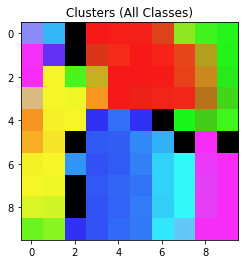

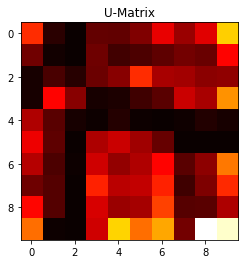

In [63]:
som.plot_map(X_train.to_numpy(), y_train.to_numpy())

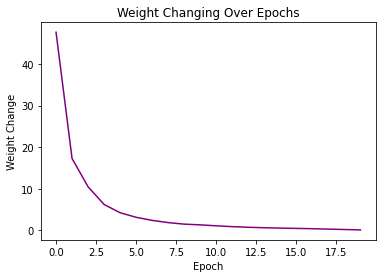

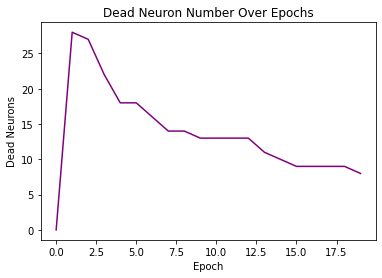

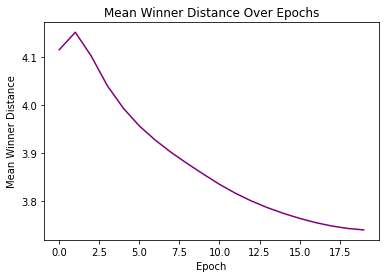

In [64]:
som.plot_train_state()

In [65]:
X_train.to_numpy().shape

(6433, 561)

In [68]:
som.transform(X_train.to_numpy())[0]

array([0.03985296, 0.03582902, 0.02780871, 0.01974901, 0.01339253,
       0.01145833, 0.00972461, 0.00826891, 0.00723831, 0.00679874,
       0.03363747, 0.02979182, 0.02346968, 0.01645922, 0.01266668,
       0.01089544, 0.00936293, 0.00783632, 0.00670658, 0.00614432,
       0.0234083 , 0.02040078, 0.01799737, 0.01510397, 0.01306246,
       0.01086948, 0.00905807, 0.00729067, 0.00602004, 0.00543661,
       0.01425472, 0.01446244, 0.01576735, 0.01871113, 0.01831326,
       0.0141597 , 0.00989701, 0.00705911, 0.00562614, 0.00488832,
       0.01135339, 0.01249871, 0.01857349, 0.03652603, 0.0506119 ,
       0.04116761, 0.02255601, 0.01073354, 0.00741616, 0.00666971,
       0.00975326, 0.01236855, 0.02738687, 0.06871899, 0.07545186,
       0.07230655, 0.06623907, 0.0431202 , 0.02645391, 0.02194758,
       0.00979319, 0.01317747, 0.04127985, 0.0767528 , 0.07076242,
       0.06383883, 0.05719954, 0.04810049, 0.0352663 , 0.03033633,
       0.01021891, 0.01402032, 0.05180767, 0.06875978, 0.06027